This notebook is used to create simple plots that do not require us running code from a repository with certain dependencies

### Scaffold split partitions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import RDLogger  
from math import floor

import os
import sys

def generate_scaffold(smiles, include_chirality=False):
    """ Obtain Bemis-Murcko scaffold from smiles
    :return: smiles of scaffold """
    RDLogger.DisableLog('rdApp.*') #disables warnings

    scaffold = MurckoScaffold.MurckoScaffoldSmiles(
        smiles=smiles, includeChirality=include_chirality)
    return scaffold

def scaffold_split(dataset_name, frac_train=0.8):
    frac_valid = (1-frac_train)/2

    np.testing.assert_almost_equal(frac_train + 2*frac_valid, 1.0)

    # get a list of SMILES for all molecules
    path_to_smiles_mapping = f"/home/rasmus.thrane/Thesis/3DInfomax/dataset/{dataset_name.replace('-','_')}/mapping/mol.csv.gz"

    smiles_df = pd.read_csv(path_to_smiles_mapping, compression="gzip")["smiles"]

    # create dict of the form {scaffold_i: [idx1, idx....]}
    all_scaffolds = {}
    for i, smiles in smiles_df.items():
        scaffold = generate_scaffold(smiles, include_chirality=True)
        if scaffold not in all_scaffolds:
            all_scaffolds[scaffold] = [i]
        else:
            all_scaffolds[scaffold].append(i)

    # sort from largest to smallest sets
    all_scaffolds = {key: sorted(value) for key, value in all_scaffolds.items()}
    all_scaffold_sets = [
        scaffold_set for (scaffold, scaffold_set) in sorted(
            all_scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)
    ]

    # get the scaffold bins since we want to use these for plots
    scaffold_bins = list(np.concatenate([[i for a in scaffold_set] for i, scaffold_set in enumerate(all_scaffold_sets)]))
    
    # get the number of unique scaffolds since we use these for plots
    n_unique_scaffolds = len(all_scaffolds)



    # get train, valid test indices
    train_cutoff = frac_train * len(smiles_df)
    valid_cutoff = (frac_train + frac_valid) * len(smiles_df)

    train_idx, valid_idx, test_idx = [], [], []
    for scaffold_set in all_scaffold_sets:
        if len(train_idx) + len(scaffold_set) > train_cutoff:
            if len(train_idx) + len(valid_idx) + len(scaffold_set) > valid_cutoff:
                test_idx.extend(scaffold_set)
            else:
                valid_idx.extend(scaffold_set)
        else:
            train_idx.extend(scaffold_set)

    assert len(set(train_idx).intersection(set(valid_idx))) == 0
    assert len(set(test_idx).intersection(set(valid_idx))) == 0
    assert len(train_idx) + len(valid_idx) + len(test_idx) == len(smiles_df)

    

    return {'train': sorted(train_idx), 'valid': sorted(valid_idx), 'test': sorted(test_idx)}, scaffold_bins, n_unique_scaffolds


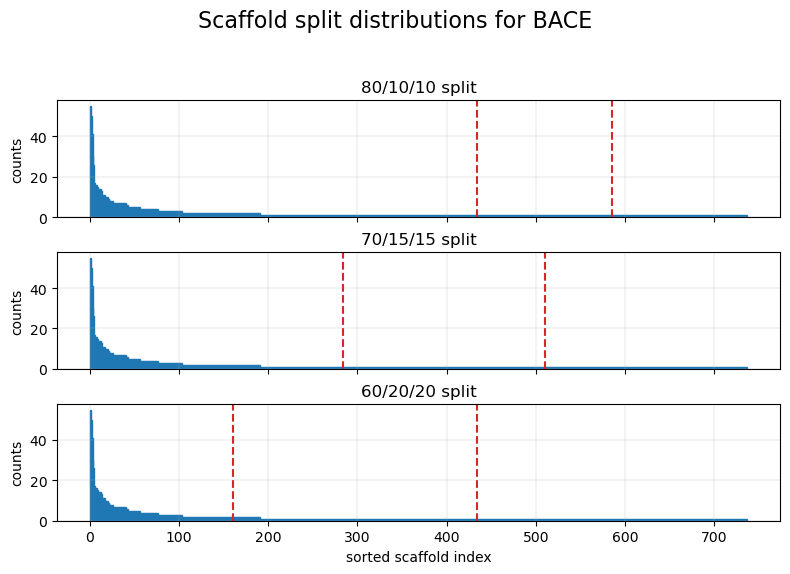

In [17]:
dataset_naming = "ogbg-molbace"
frac_trains = [0.8, 0.7, 0.6]
split_namings = ["80/10/10", "70/15/15", "60/20/20" ]

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
for i, frac_train in enumerate(frac_trains):
    split_naming = split_namings[i]

    custom_split, scaffold_bins, n_unique_scaffolds = scaffold_split(dataset_naming, frac_train)
    n_molecules = len(scaffold_bins)

    ax = axes[i]

    counts, bin_edges, _ = ax.hist(scaffold_bins, bins=n_unique_scaffolds, edgecolor='#1f77b4')

    train_cutoff = np.where(np.cumsum(counts) > floor(frac_train * n_molecules))[0][0]
    valid_cutoff = np.where(np.cumsum(counts) > floor((frac_train + (1 - frac_train) / 2) * n_molecules))[0][0]

    train_line = bin_edges[train_cutoff]
    valid_line = bin_edges[valid_cutoff]

    ax.axvline(train_line, color="#d62728", ls="--", label="train/val split")
    ax.axvline(valid_line, color="#d62728", ls="--")
    ax.grid(True, which="major", linewidth=0.2)
    ax.set_title(f"{split_naming} split")
    ax.set_ylabel("counts")

axes[-1].set_xlabel("sorted scaffold index")
fig.suptitle(f"Scaffold split distributions for BACE", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=0.3)  # adjust vertical space between plots
plt.show()